## AIM: Obtain patient-level predictions from models

For each model patient-level predictions will be obtained. These patient-level predictions will be determined in two ways: 1) Majority epoch prediction, 2) summing the propabilities of the epoch predictions and taking the highest probability class.

In [2]:
import numpy as np
import pandas as pd
import sklearn
import pickle
import joblib
import mne
import os
import matplotlib.pyplot as plt

from sklearn import svm
from sklearn.preprocessing import StandardScaler
from sklearn import metrics
from sklearn.model_selection import StratifiedGroupKFold, GridSearchCV, GroupShuffleSplit
from sklearn.model_selection import train_test_split, cross_val_score, cross_val_predict, cross_validate
from sklearn.metrics import classification_report, confusion_matrix, f1_score, make_scorer, fbeta_score
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.impute import SimpleImputer
from sklearn import preprocessing
from sklearn.decomposition import PCA
from sklearn.compose import ColumnTransformer
from sklearn.svm import SVC
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier

%matplotlib inline

## Loading in feature data

#### Boruta-selected stat features

In [3]:
df_stat_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\df_selected_stat_features.pkl')
df_stat_features = df_stat_features.dropna(subset=['diagnosis'])
df_stat_features.sample(7)

,ID,epoch,diagnosis,EC_l_frontal_delta_mean,EC_l_frontal_delta_median,EC_l_frontal_theta_std,EC_l_frontal_theta_mean,EC_l_frontal_theta_median,EC_l_frontal_alpha_std,EC_l_frontal_alpha_mean,...,ratio_r_posterior_delta_median,ratio_r_posterior_theta_mean,ratio_r_posterior_theta_median,ratio_r_posterior_alpha_median,ratio_r_posterior_beta_std,ratio_r_posterior_beta_mean,ratio_r_posterior_beta_median,ratio_r_posterior_gamma_std,ratio_r_posterior_gamma_mean,ratio_r_posterior_gamma_median
7030,sub-88069605,11,MDD,0.076532,0.076532,0.051107,0.070157,0.070157,0.043372,0.052370,...,1.137621,2.080311,1.450934,1.209374,0.569096,0.677018,0.537636,0.160574,0.284438,0.243376
116,sub-87966473,9,SMC,0.058226,0.058226,0.032489,0.048807,0.048807,0.060065,0.059739,...,0.875520,1.676429,0.984896,1.631296,2.589486,2.756452,1.938398,2.977767,4.214347,3.451591
3705,sub-88038789,10,ADHD,0.080139,0.080139,0.029354,0.045108,0.045108,0.022347,0.033189,...,0.562573,1.230160,0.690682,2.013877,2.526332,3.292091,2.635946,1.812773,2.947228,2.543985
2732,sub-88025641,9,MDD,0.053408,0.053408,0.051952,0.066287,0.066287,0.043721,0.069594,...,1.137116,1.510540,1.038437,0.994827,0.785094,1.191000,1.038040,0.173991,0.457261,0.430155
394,sub-87967869,11,SMC,0.052401,0.052401,0.040247,0.065630,0.065630,0.053221,0.074115,...,0.682681,2.181227,1.074562,1.468459,1.039296,1.155269,0.801916,0.319982,0.667459,0.604392
5360,sub-88053361,9,ADHD,0.064228,0.064228,0.042115,0.064563,0.064563,0.035774,0.063155,...,1.043228,1.378824,0.932434,1.462402,2.244452,2.389230,1.979380,9.721529,5.821700,3.051471
63,sub-87966337,4,SMC,0.063364,0.063364,0.023589,0.041360,0.041360,0.044589,0.063036,...,0.758934,1.406875,1.055762,2.553059,0.938524,1.380201,1.125722,1.033863,0.924852,0.598553


In [4]:
df_stat_features['diagnosis'].value_counts()

diagnosis
SMC        540
HEALTHY    540
MDD        540
ADHD       540
OCD        540
Name: count, dtype: int64

In [5]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_stat_features_ec = df_stat_features[df_stat_features.columns[~(df_stat_features.columns.str.startswith('EO') | df_stat_features.columns.str.startswith('ratio'))]]
df_stat_features_eo = df_stat_features[df_stat_features.columns[~(df_stat_features.columns.str.startswith('EC') | df_stat_features.columns.str.startswith('ratio'))]]
df_stat_features_ratio = df_stat_features[df_stat_features.columns[~(df_stat_features.columns.str.startswith('EC') | df_stat_features.columns.str.startswith('EO'))]]

#### Boruta-selected stat features + connectivity features

In [6]:
df_stat_conn_features = pd.read_pickle(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\TD-BRAIN\TD-BRAIN_extracted_features\df_selected_stat_conn_features.pkl')
df_stat_conn_features = df_stat_conn_features.dropna(subset=['diagnosis'])
df_stat_conn_features.sample(7)

,ID,epoch,diagnosis,EC_l_frontal_delta_std,EC_l_frontal_delta_mean,EC_l_frontal_delta_median,EC_l_frontal_theta_std,EC_l_frontal_theta_mean,EC_l_frontal_theta_median,EC_l_frontal_alpha_std,...,ratio_gamma_m_central-r_central,ratio_gamma_m_central-l_posterior,ratio_gamma_m_central-m_posterior,ratio_gamma_m_central-r_posterior,ratio_gamma_r_central-l_posterior,ratio_gamma_r_central-m_posterior,ratio_gamma_r_central-r_posterior,ratio_gamma_l_posterior-m_posterior,ratio_gamma_l_posterior-r_posterior,ratio_gamma_m_posterior-r_posterior
2107,sub-88059977,8,OCD,0.073337,0.084912,0.084912,0.029241,0.053775,0.053775,0.029529,...,0.982214,0.974720,0.969493,0.975628,0.969378,0.967691,0.981820,0.974340,0.977851,0.976760
1447,sub-88042837,8,MDD,0.020080,0.023608,0.023608,0.026287,0.036543,0.036543,0.083240,...,1.051906,1.065304,1.048665,1.051999,1.057238,1.041472,1.039040,1.035953,1.024648,1.012958
1768,sub-88053273,5,ADHD,0.090078,0.107592,0.107592,0.044314,0.072483,0.072483,0.013410,...,1.009277,1.023140,1.022519,1.019360,1.061452,1.049543,1.047349,1.026094,1.025365,1.033260
6,sub-87964717,7,SMC,0.055966,0.053898,0.053898,0.049081,0.053144,0.053144,0.060128,...,1.025659,0.985840,1.010758,1.025635,0.980963,1.002243,1.002352,0.982732,0.975538,0.999211
2372,sub-88067449,9,ADHD,0.055815,0.077431,0.077431,0.043100,0.069697,0.069697,0.042417,...,0.998867,0.994267,1.007250,1.013097,0.981025,0.996444,1.001201,0.994163,1.012211,1.009208
1841,sub-88053817,6,OCD,0.080115,0.092202,0.092202,0.029934,0.054633,0.054633,0.023866,...,0.982595,0.980168,0.966569,0.975643,0.996130,0.981155,0.986015,1.001214,1.040697,1.025261
894,sub-88005849,7,MDD,0.037747,0.051113,0.051113,0.034287,0.057357,0.057357,0.050205,...,1.022030,1.068002,1.035602,1.042758,1.082556,1.044469,1.041686,1.044112,1.067460,1.043759


In [7]:
df_stat_conn_features['diagnosis'].value_counts()

diagnosis
SMC        540
HEALTHY    540
MDD        540
ADHD       540
OCD        540
Name: count, dtype: int64

In [8]:
# create 3 feature sets [EC, EO, ratio] with column ['ID', 'age', 'gender', 'diagnosis', 'epoch']
df_stat_conn_features_ec = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EO') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_eo = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('ratio'))]]
df_stat_conn_features_ratio = df_stat_conn_features[df_stat_conn_features.columns[~(df_stat_conn_features.columns.str.startswith('EC') | df_stat_conn_features.columns.str.startswith('EO'))]]

In [9]:
print(df_stat_conn_features_ratio.shape)
print(df_stat_conn_features_ec.shape)
print(df_stat_conn_features_eo.shape)

(2700, 185)
(2700, 322)
(2700, 304)


## Baseline models

### EC

#### SVM

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_svm_ec.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_ec['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_ec.columns if 'EC' in num_col]
 
X = df_stat_features_ec[numeric_cols]
Y = df_stat_features_ec['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[20:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)


steps = [('col_trans', col_trans), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_ec['ID'], 'diagnosis': df_stat_features_ec['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_ec.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

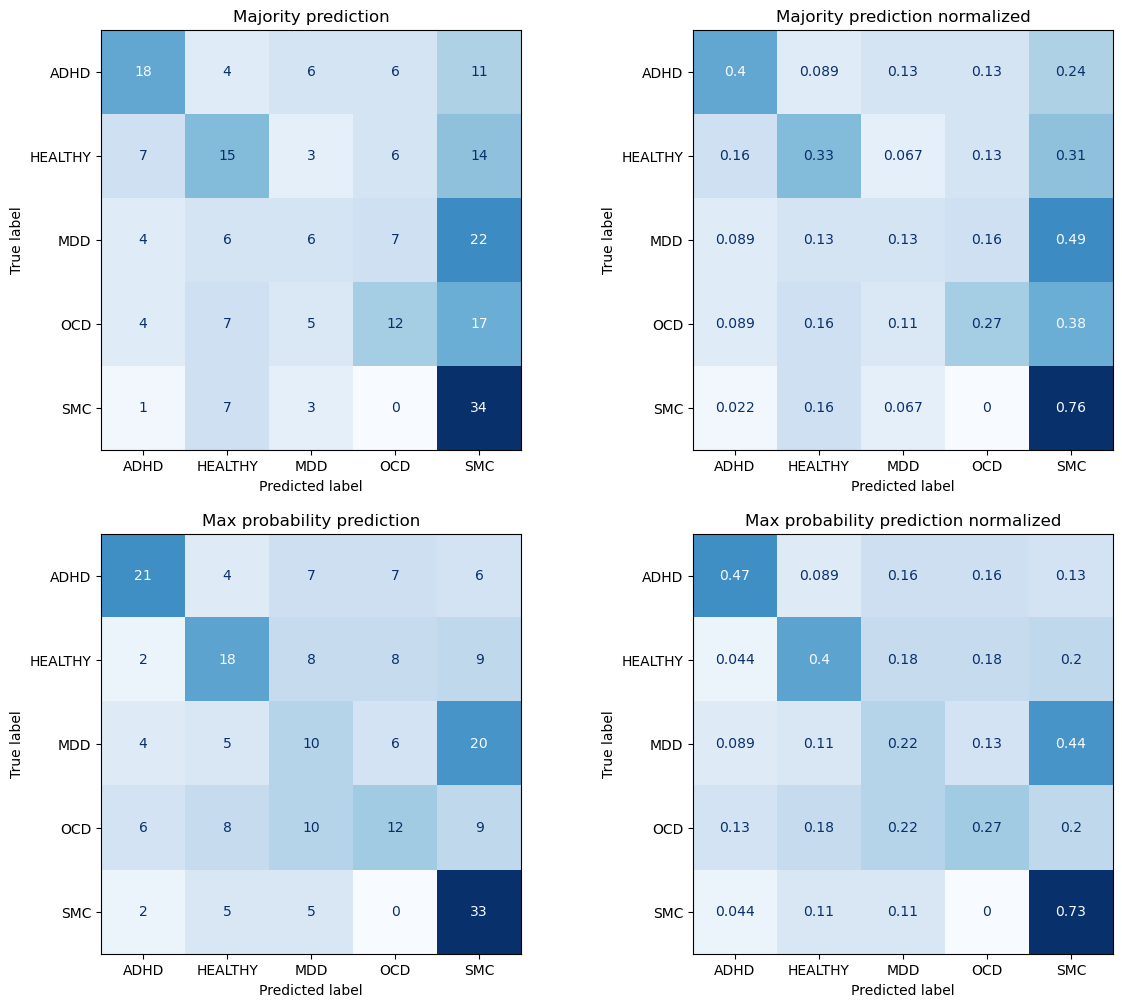

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### RF

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_rf_ec.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_ec['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_ec.columns if 'EC' in num_col]
 
X = df_stat_features_ec[numeric_cols]
Y = df_stat_features_ec['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[4:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_ec['ID'], 'diagnosis': df_stat_features_ec['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_ec.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

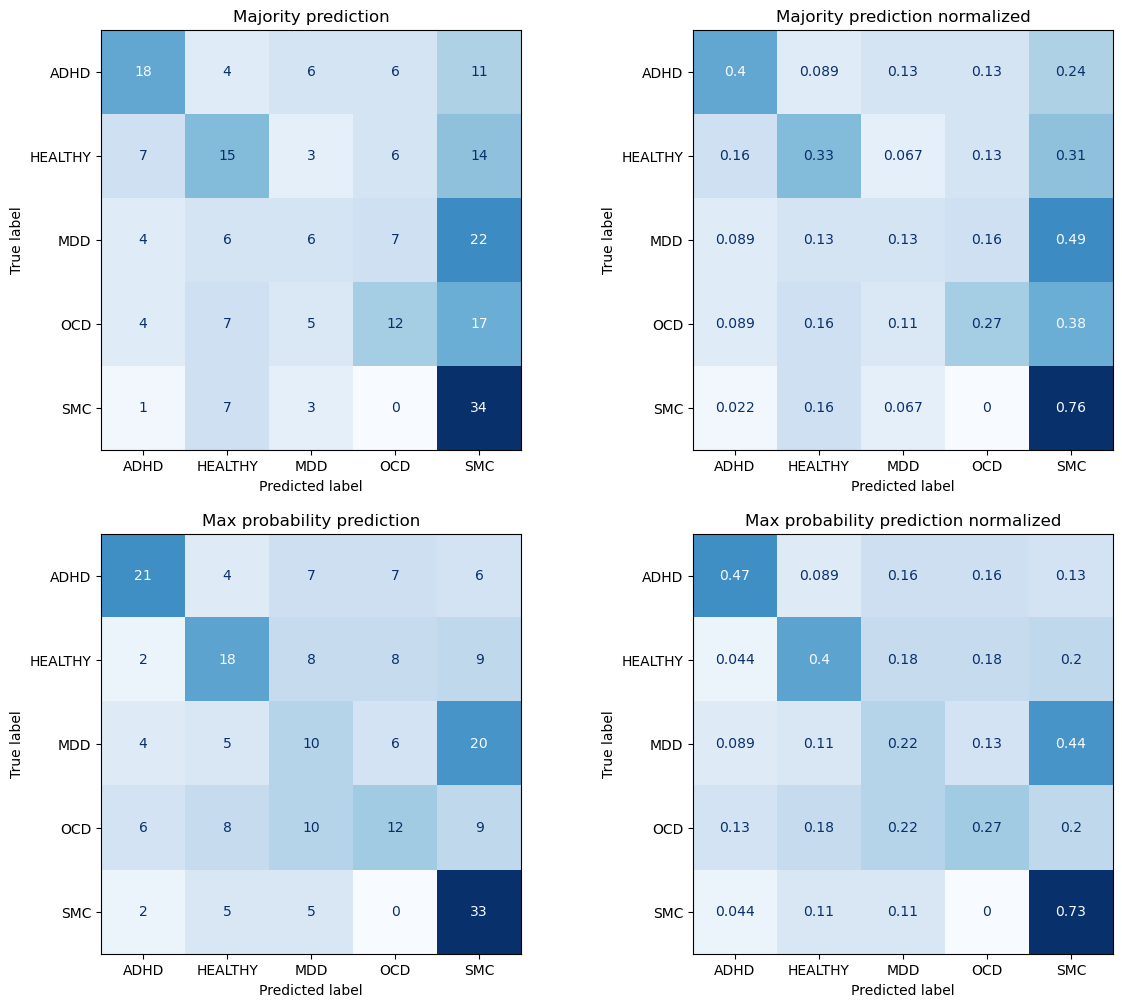

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GBC

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_gbc_ec.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_ec['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_ec.columns if 'EC' in num_col]
 
X = df_stat_features_ec[numeric_cols]
Y = df_stat_features_ec['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[5:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)
# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_ec['ID'], 'diagnosis': df_stat_features_ec['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_ec.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

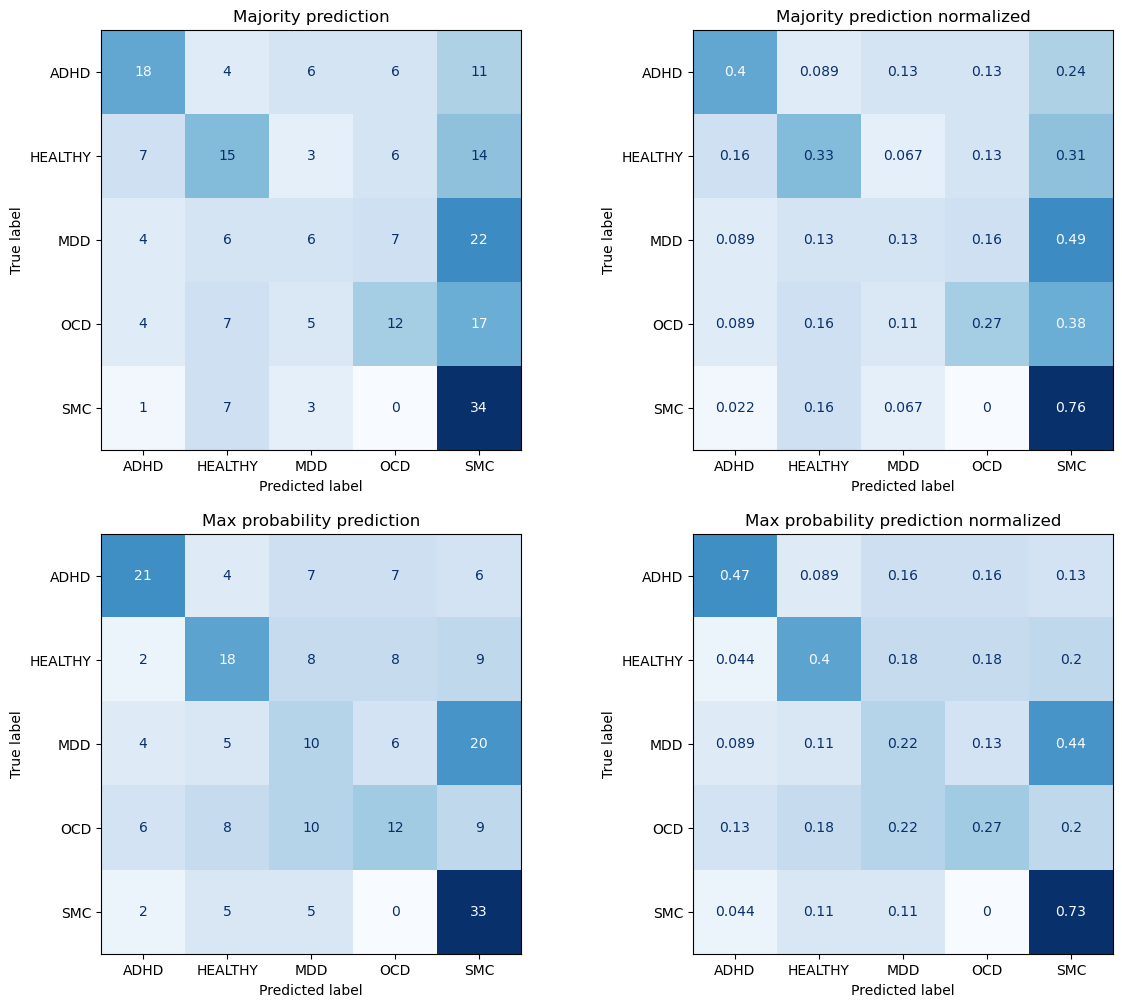

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

### EO

#### SVM

In [10]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_svm_eo.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [42]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_eo['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_eo.columns if 'EO' in num_col]
 
X = df_stat_features_eo[numeric_cols]
Y = df_stat_features_eo['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[20:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)


steps = [('col_trans', col_trans), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_eo['ID'], 'diagnosis': df_stat_features_eo['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [67]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_eo.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [71]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

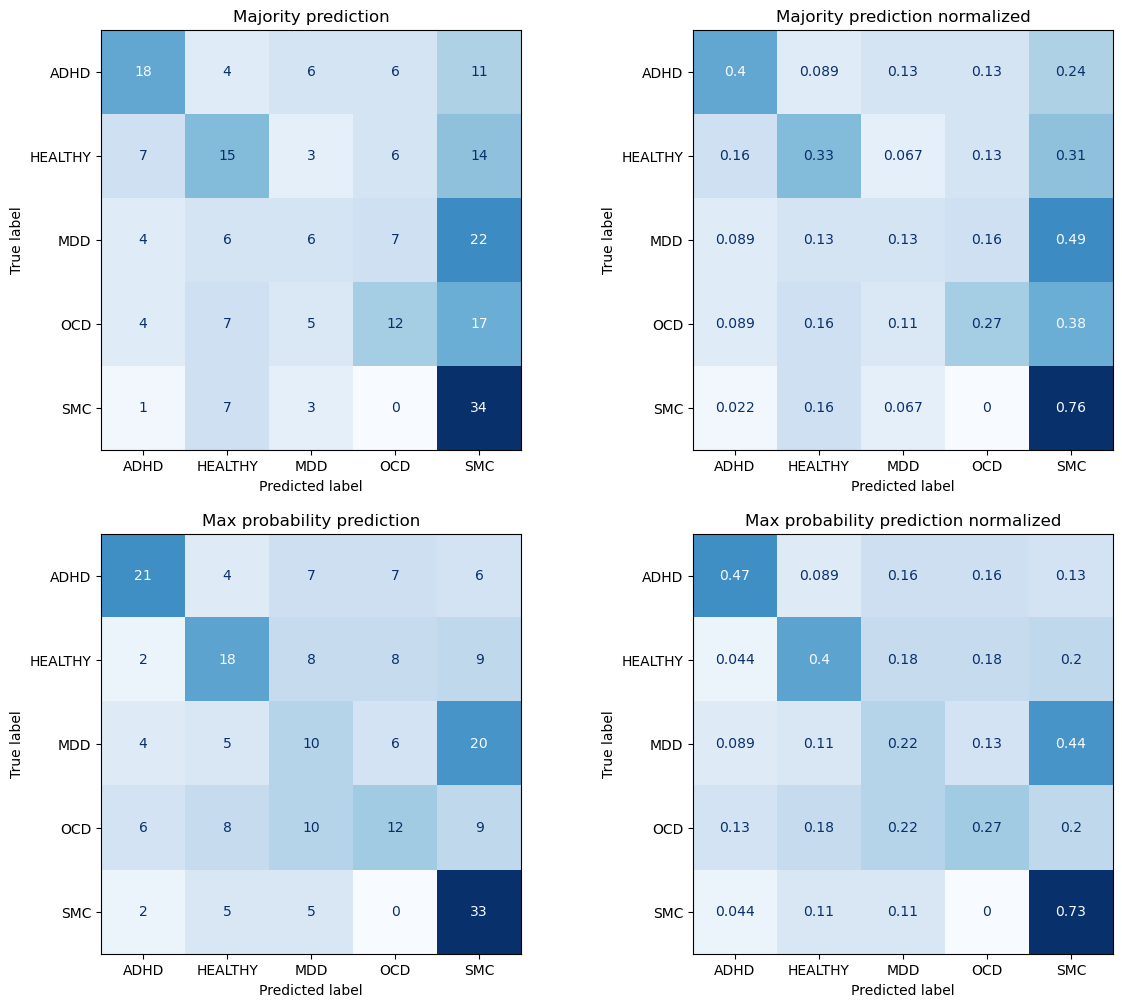

In [79]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### RF

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_rf_eo.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_eo['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_eo.columns if 'EO' in num_col]
 
X = df_stat_features_eo[numeric_cols]
Y = df_stat_features_eo['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[4:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_eo['ID'], 'diagnosis': df_stat_features_eo['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_eo.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

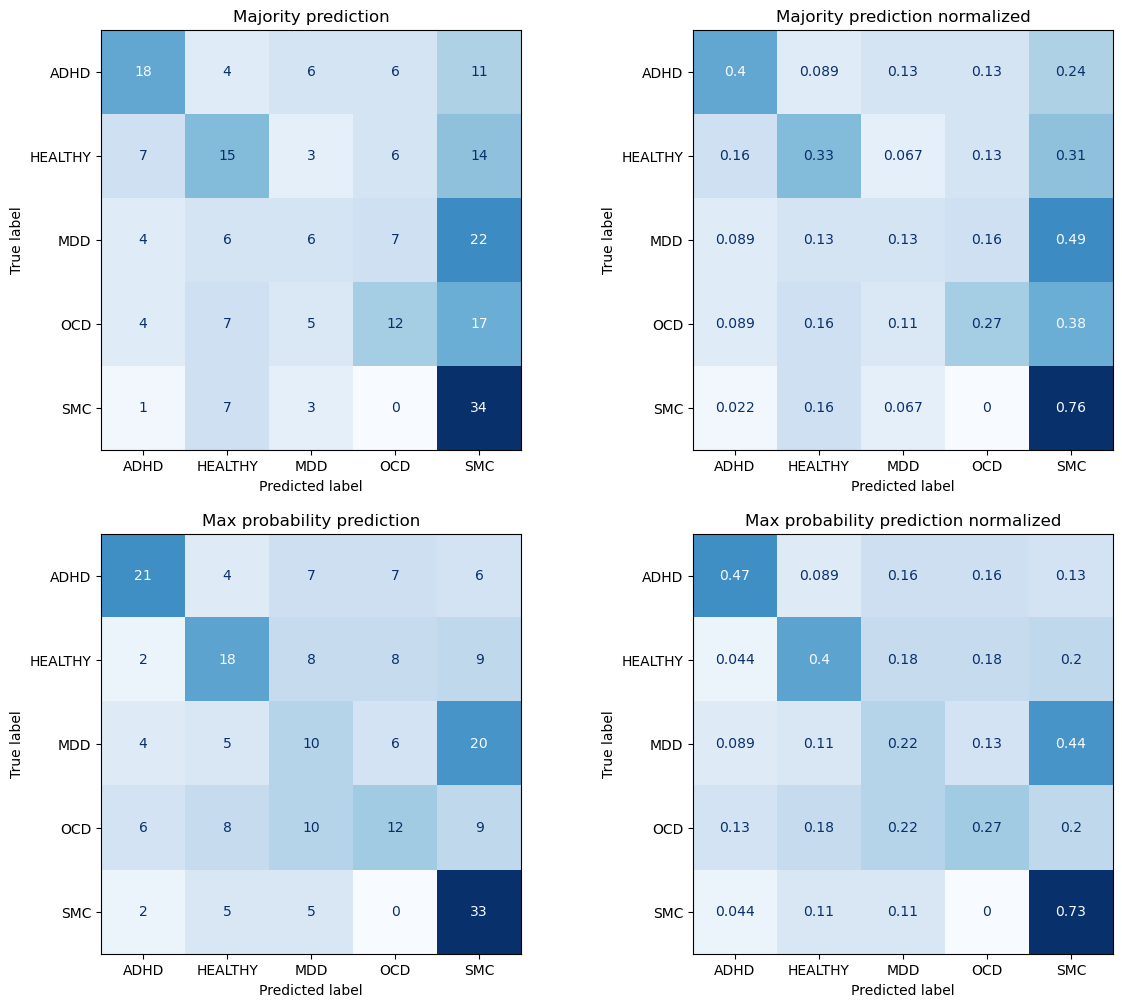

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GBC

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_gbc_eo.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_eo['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_eo.columns if 'EO' in num_col]
 
X = df_stat_features_eo[numeric_cols]
Y = df_stat_features_eo['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[5:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)
# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_eo['ID'], 'diagnosis': df_stat_features_eo['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_eo.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

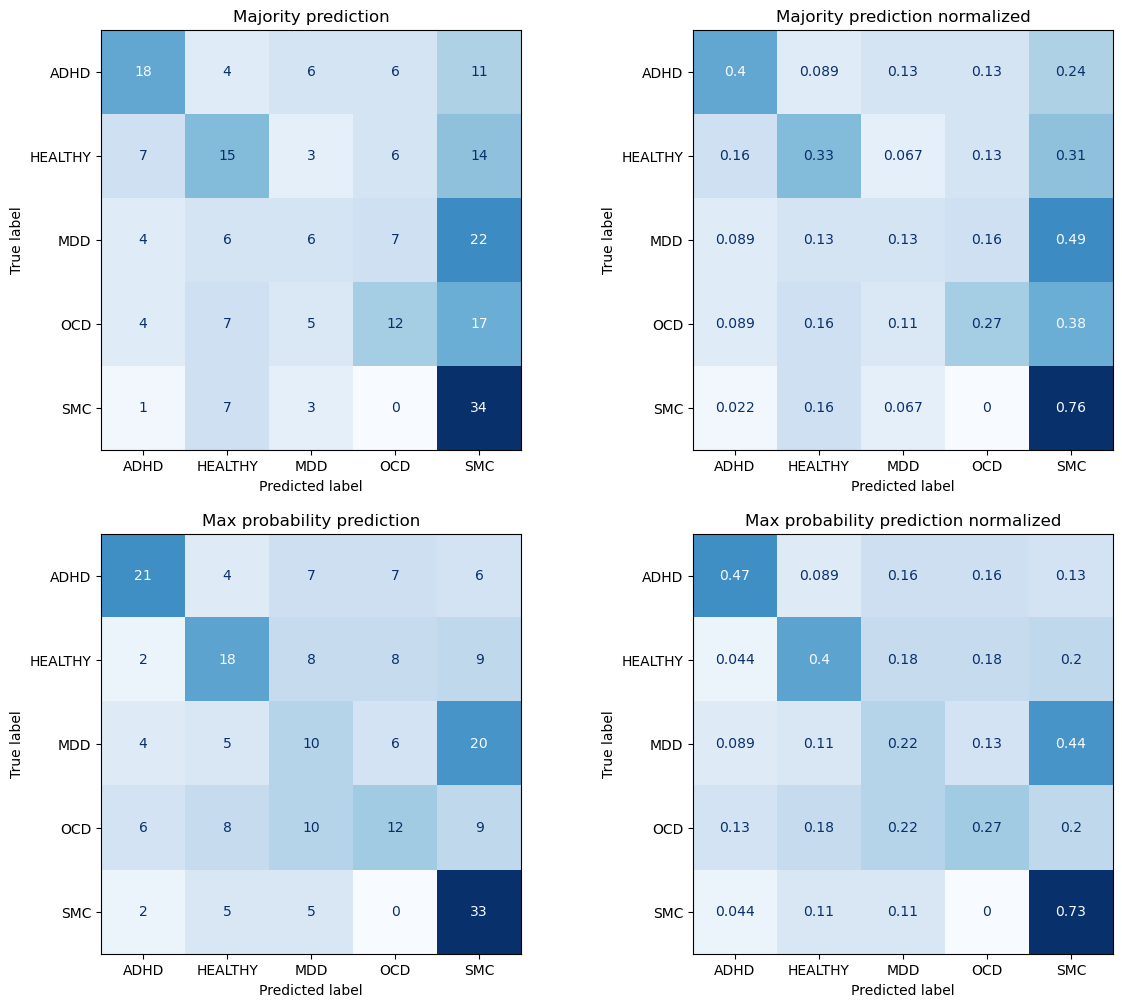

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

### Ratio

#### SVM

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_svm_ratio.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_ratio['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_ratio.columns if 'ratio' in num_col]
 
X = df_stat_features_ratio[numeric_cols]
Y = df_stat_features_ratio['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[20:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)


steps = [('col_trans', col_trans), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_ratio['ID'], 'diagnosis': df_stat_features_ratio['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_ratio.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

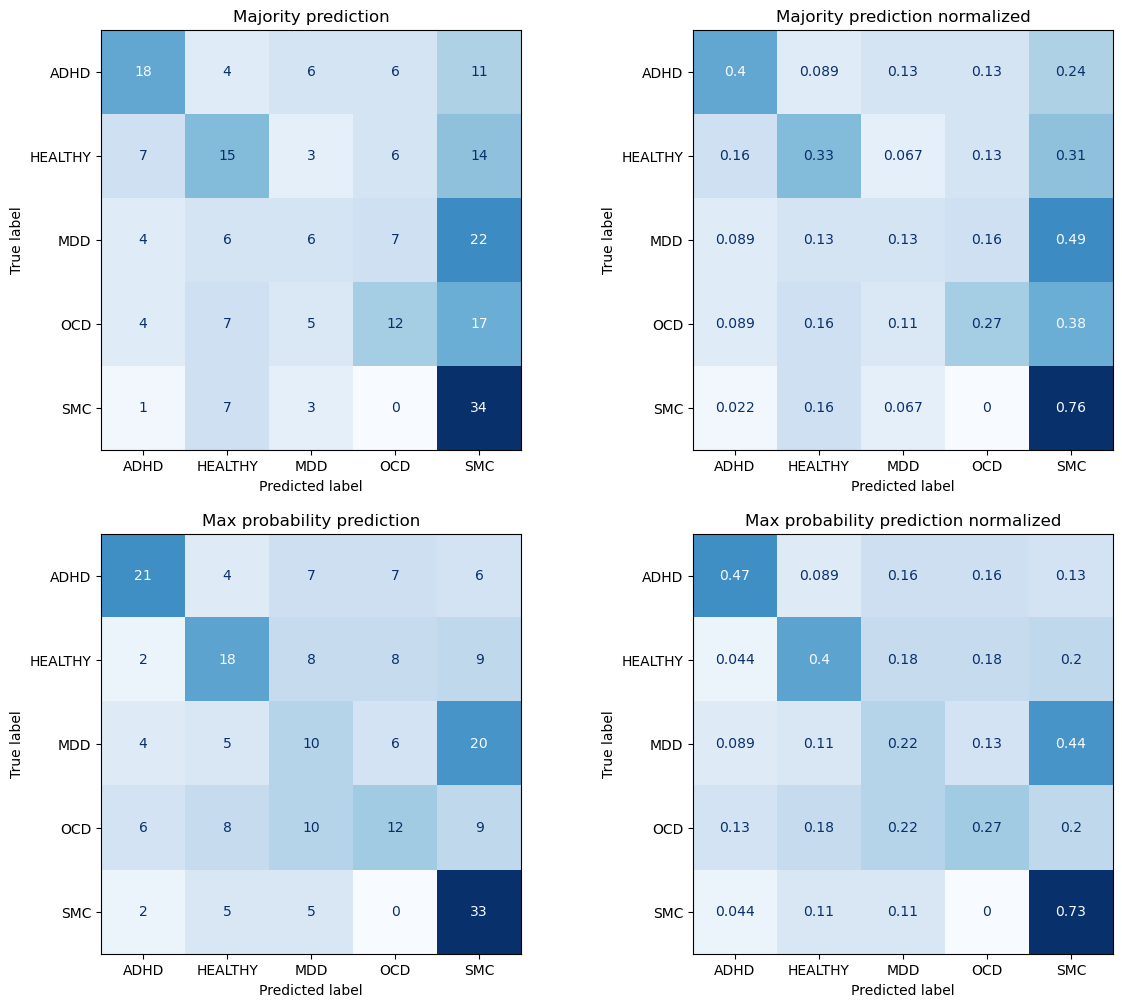

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### RF

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_rf_ratio.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_ratio['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_ratio.columns if 'ratio' in num_col]
 
X = df_stat_features_ratio[numeric_cols]
Y = df_stat_features_ratio['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[4:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_ratio['ID'], 'diagnosis': df_stat_features_ratio['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_ratio.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

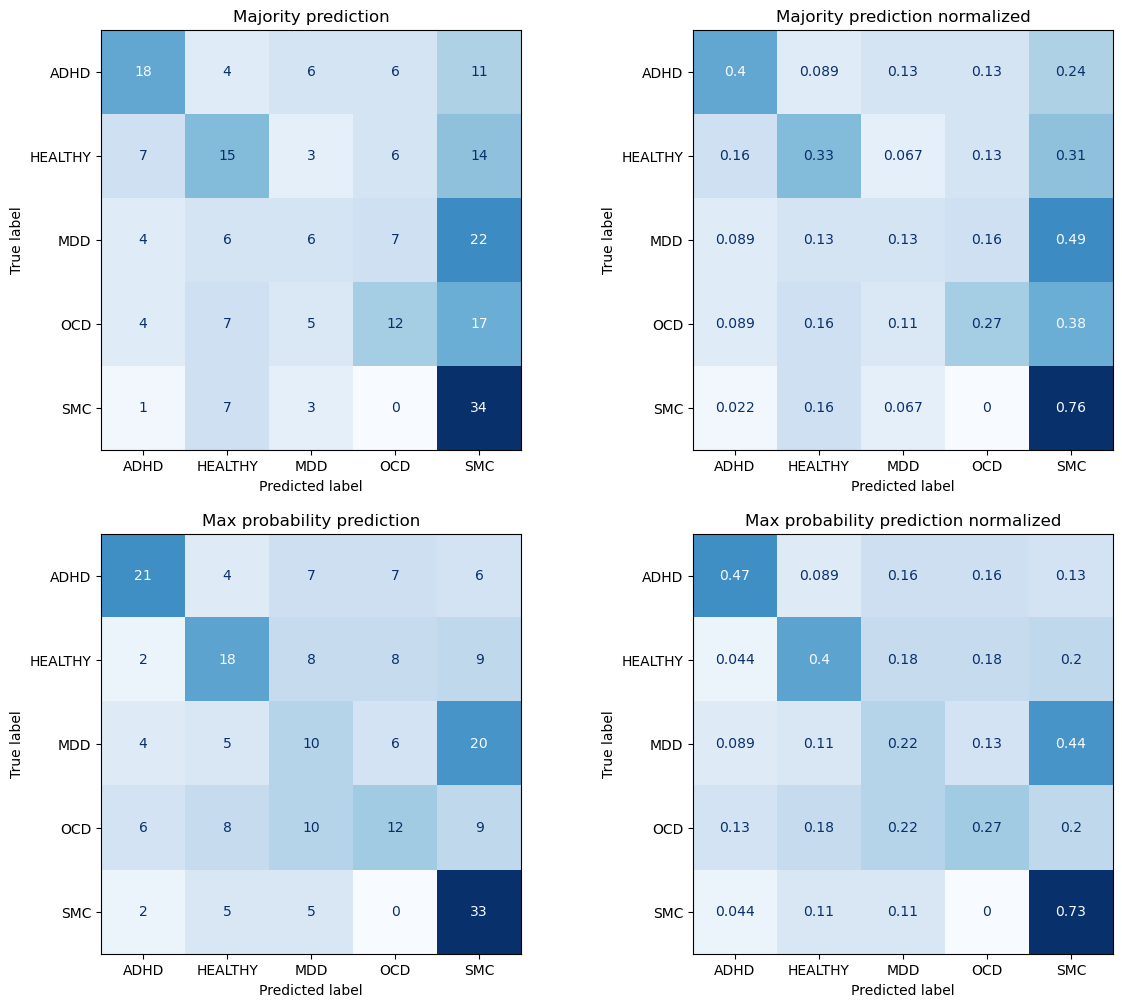

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GBC

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_stat_gbc_ratio.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_features_ratio['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_features_ratio.columns if 'ratio' in num_col]
 
X = df_stat_features_ratio[numeric_cols]
Y = df_stat_features_ratio['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[5:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)
# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_features_ratio['ID'], 'diagnosis': df_stat_features_ratio['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_features_ratio.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

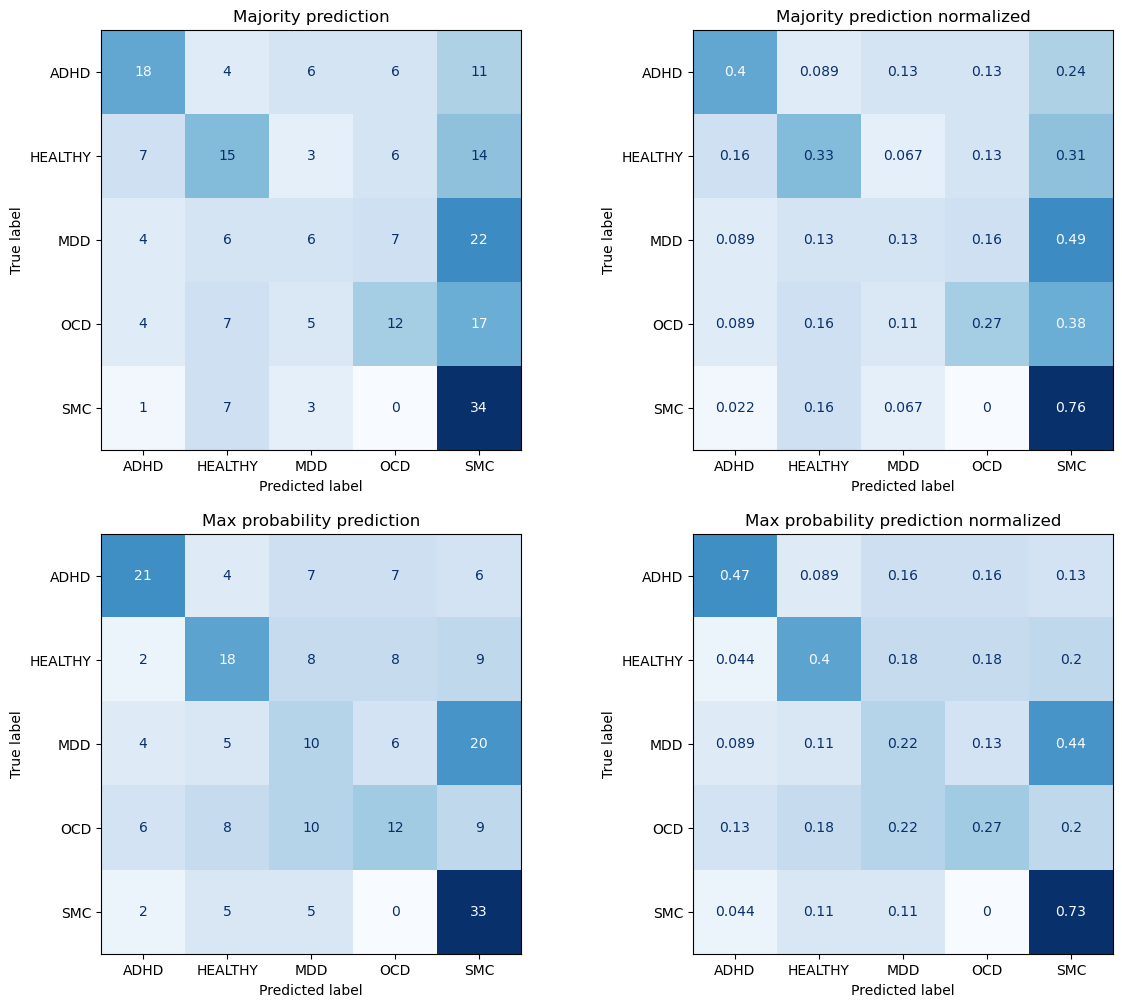

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

## Extended models

### EC

#### SVM

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_svm_ec.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_ec['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_ec.columns if 'EC' in num_col]
 
X = df_stat_conn_features_ec[numeric_cols]
Y = df_stat_conn_features_ec['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[20:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)


steps = [('col_trans', col_trans), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_ec['ID'], 'diagnosis': df_stat_conn_features_ec['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_ec.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

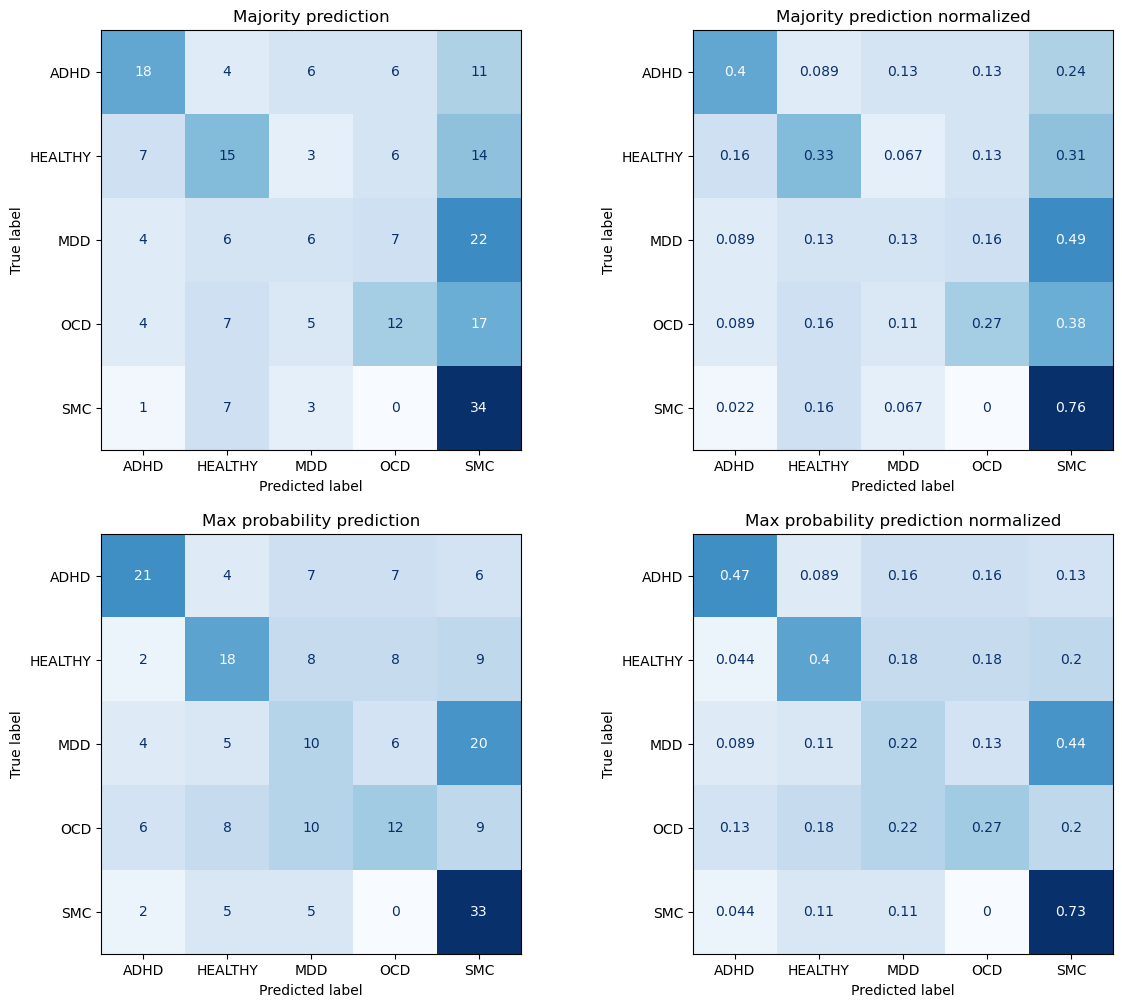

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### RF

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_rf_ec.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_ec['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_ec.columns if 'EC' in num_col]
 
X = df_stat_conn_features_ec[numeric_cols]
Y = df_stat_conn_features_ec['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[4:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_ec['ID'], 'diagnosis': df_stat_conn_features_ec['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_ec.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

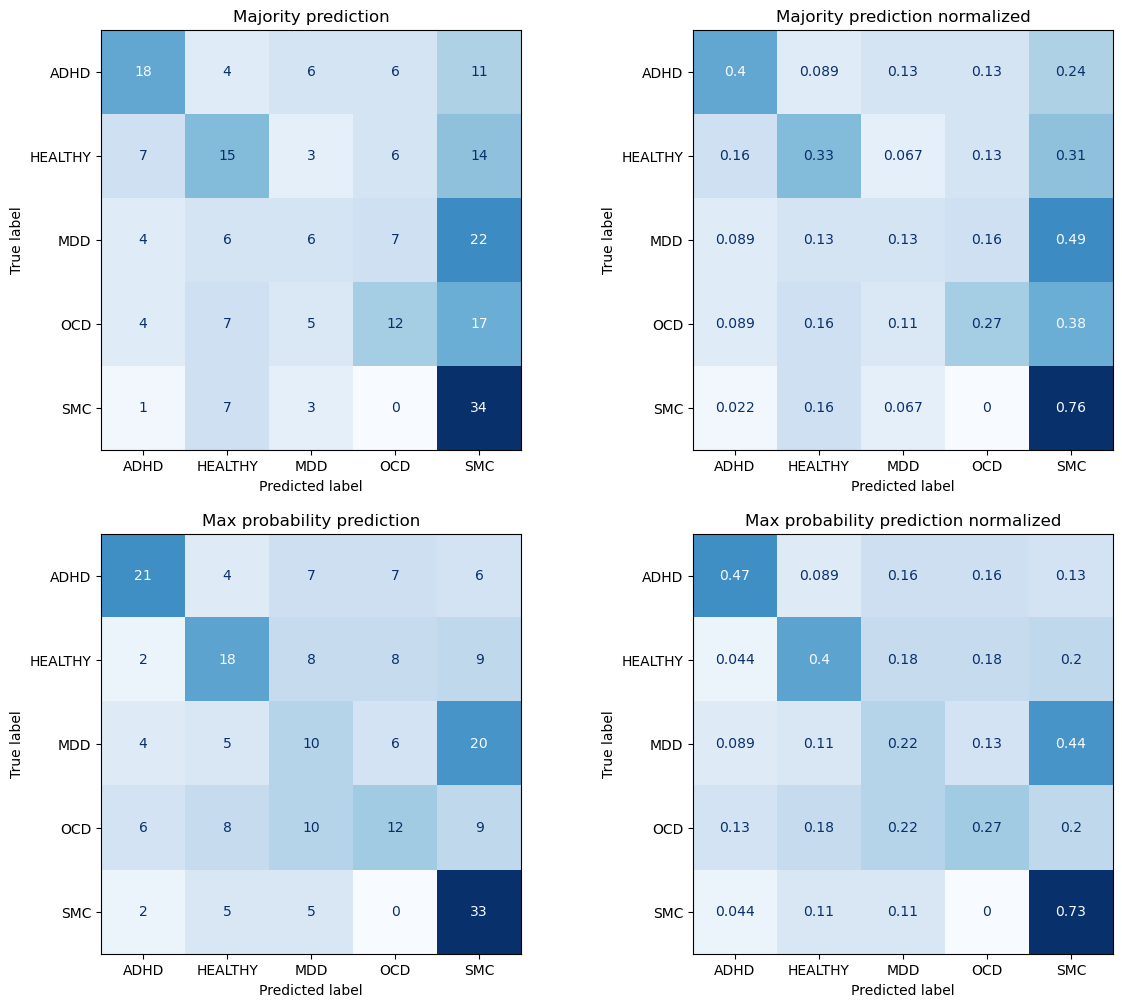

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GBC

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_gbc_ec.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_ec['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_ec.columns if 'EC' in num_col]
 
X = df_stat_conn_features_ec[numeric_cols]
Y = df_stat_conn_features_ec['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[5:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)
# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_ec['ID'], 'diagnosis': df_stat_conn_features_ec['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_ec.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

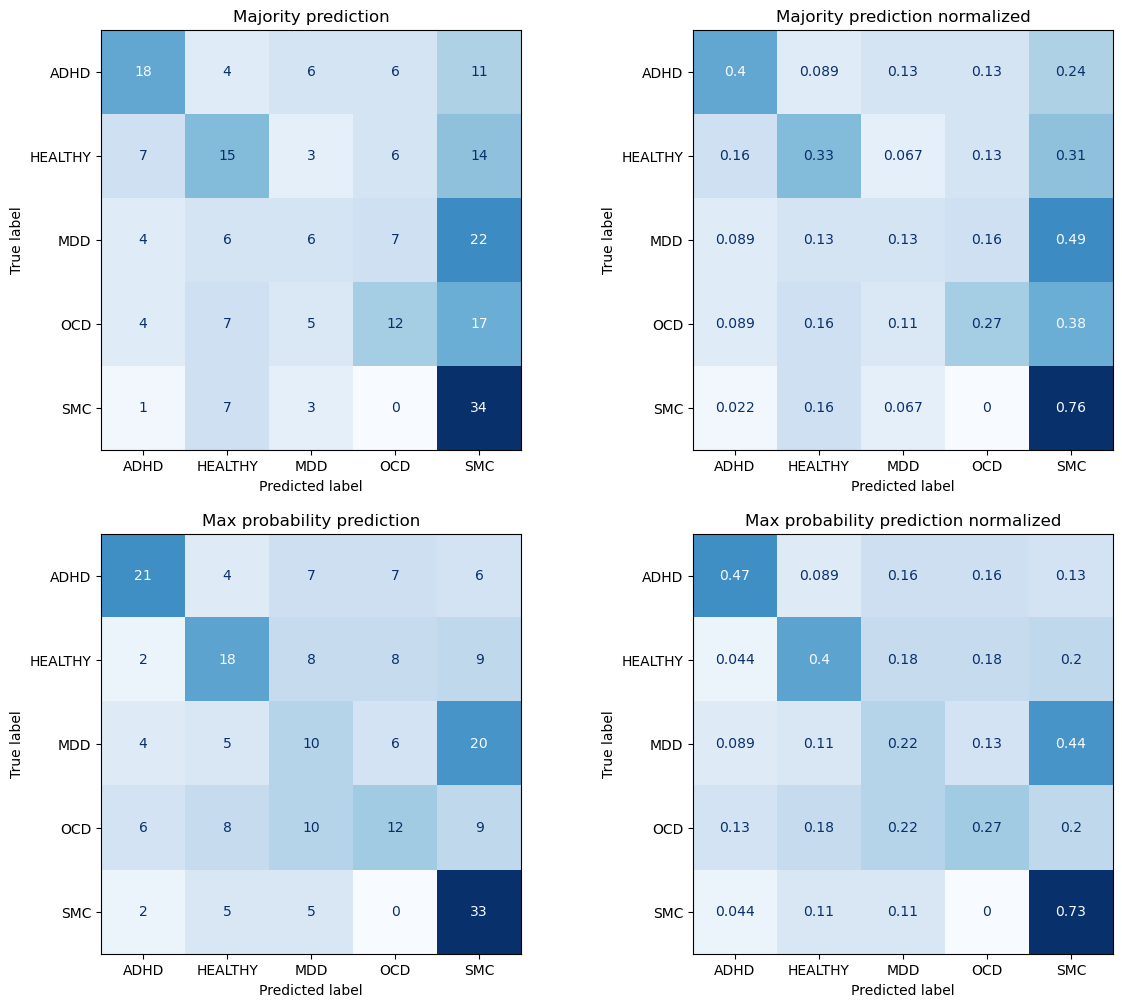

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

### EO

#### SVM

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_svm_eo.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_eo['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_eo.columns if 'EO' in num_col]
 
X = df_stat_conn_features_eo[numeric_cols]
Y = df_stat_conn_features_eo['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[20:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)


steps = [('col_trans', col_trans), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_eo['ID'], 'diagnosis': df_stat_conn_features_eo['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_eo.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

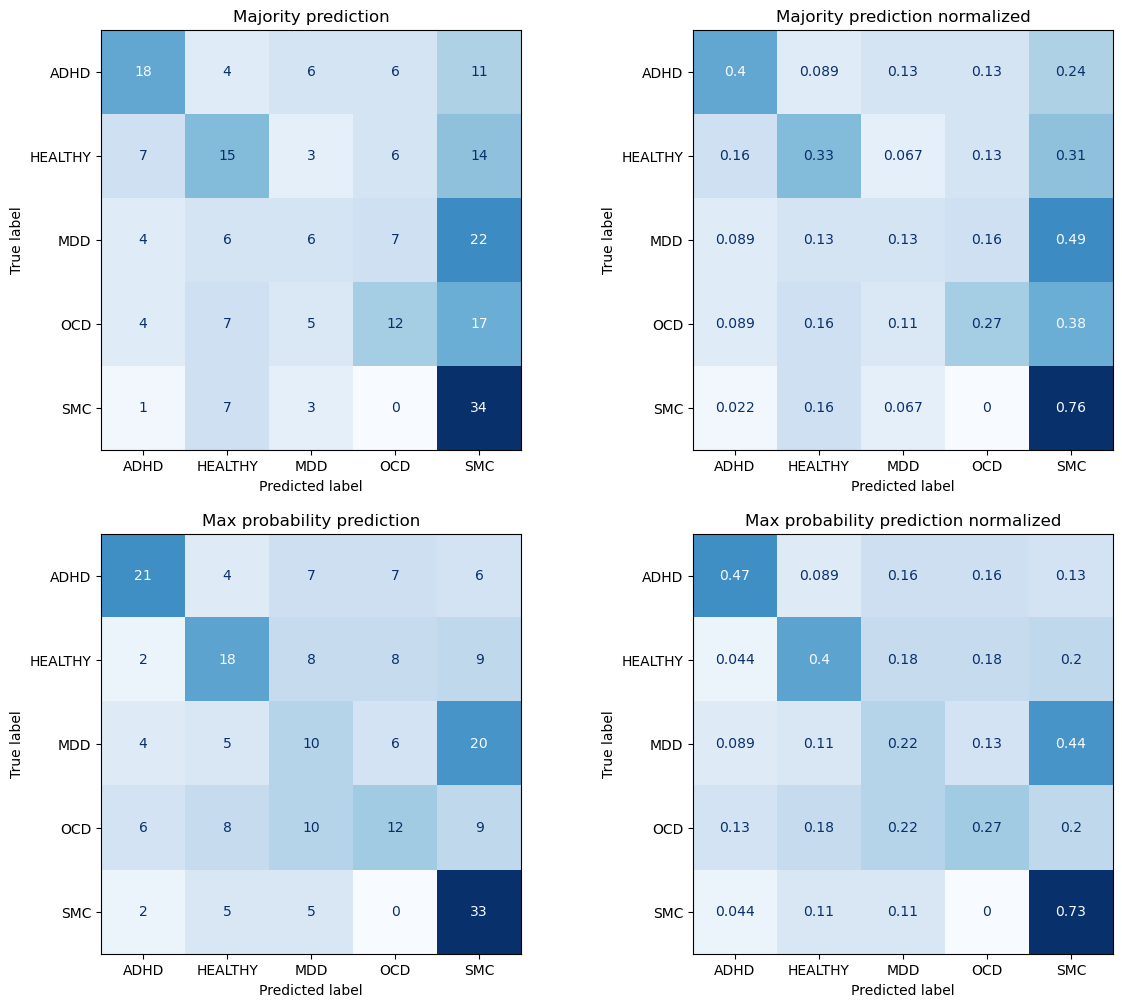

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### RF

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_rf_eo.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_eo['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_eo.columns if 'EO' in num_col]
 
X = df_stat_conn_features_eo[numeric_cols]
Y = df_stat_conn_features_eo['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[4:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_eo['ID'], 'diagnosis': df_stat_conn_features_eo['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_eo.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

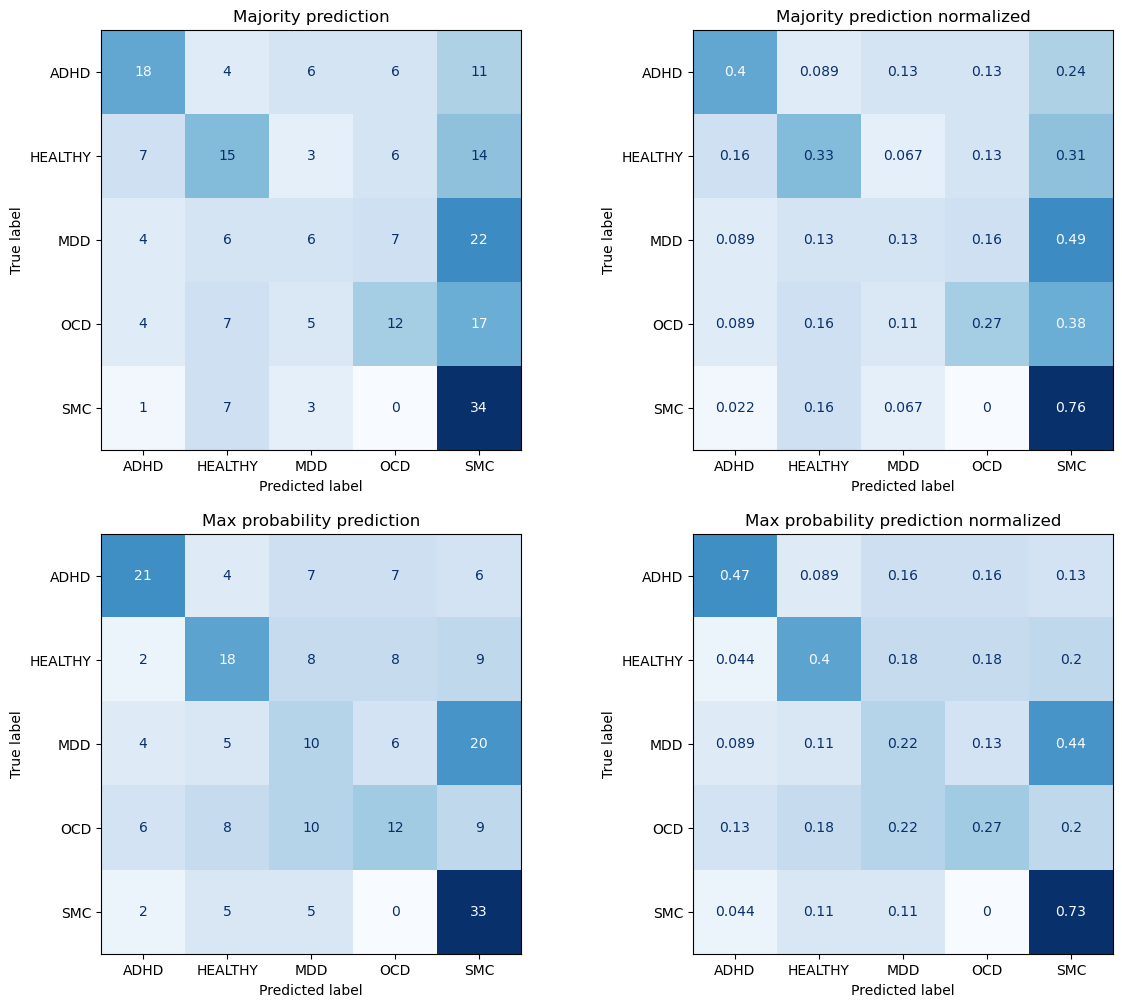

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GBC

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_gbc_eo.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_eo['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_eo.columns if 'EO' in num_col]
 
X = df_stat_conn_features_eo[numeric_cols]
Y = df_stat_conn_features_eo['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[5:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)
# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_eo['ID'], 'diagnosis': df_stat_conn_features_eo['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_eo.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

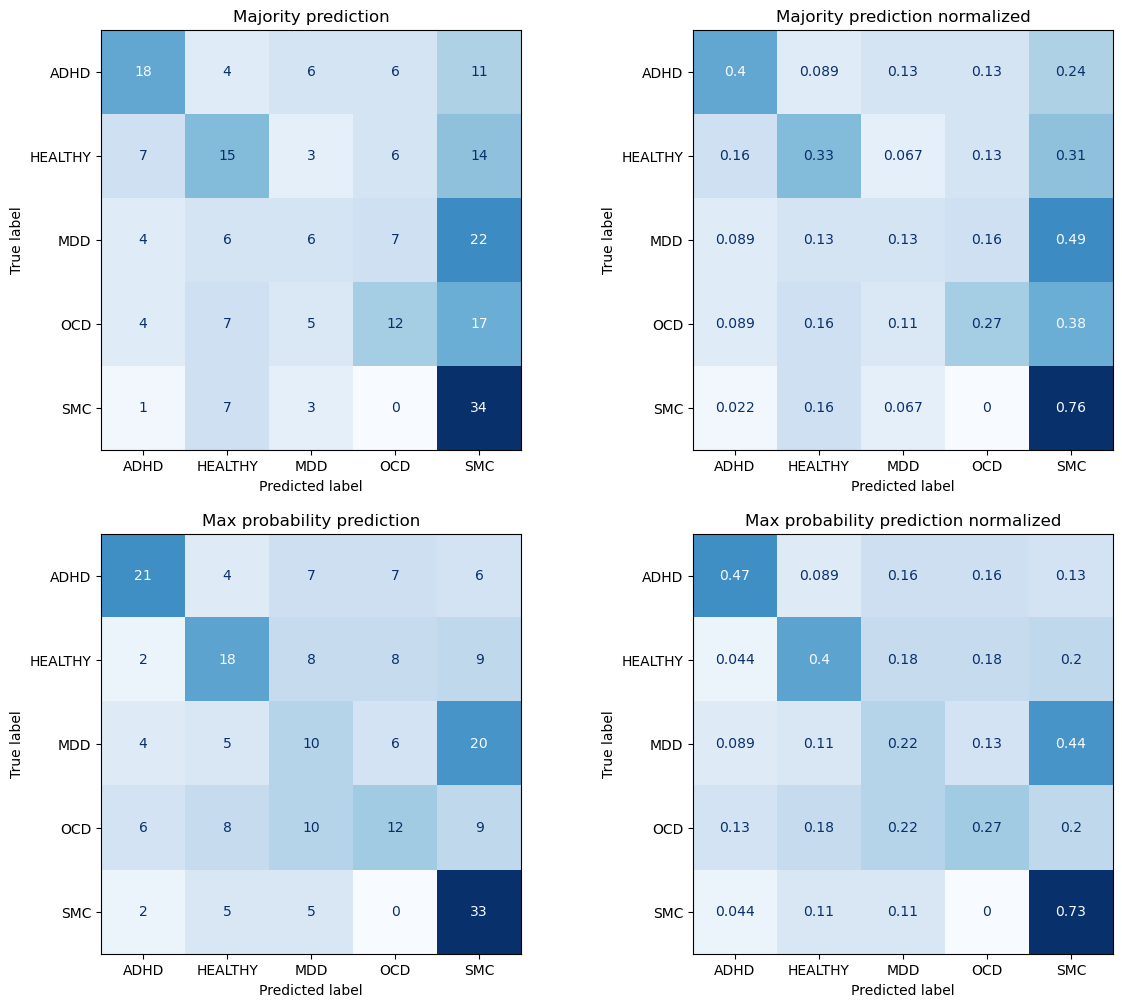

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

### Ratio

#### SVM

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_svm_ratio.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_ratio['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_ratio.columns if 'ratio' in num_col]
 
X = df_stat_conn_features_ratio[numeric_cols]
Y = df_stat_conn_features_ratio['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[20:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)


steps = [('col_trans', col_trans), ('rbf_svm', OneVsRestClassifier(SVC(**best_params, probability=True)))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_ratio['ID'], 'diagnosis': df_stat_conn_features_ratio['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_ratio.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

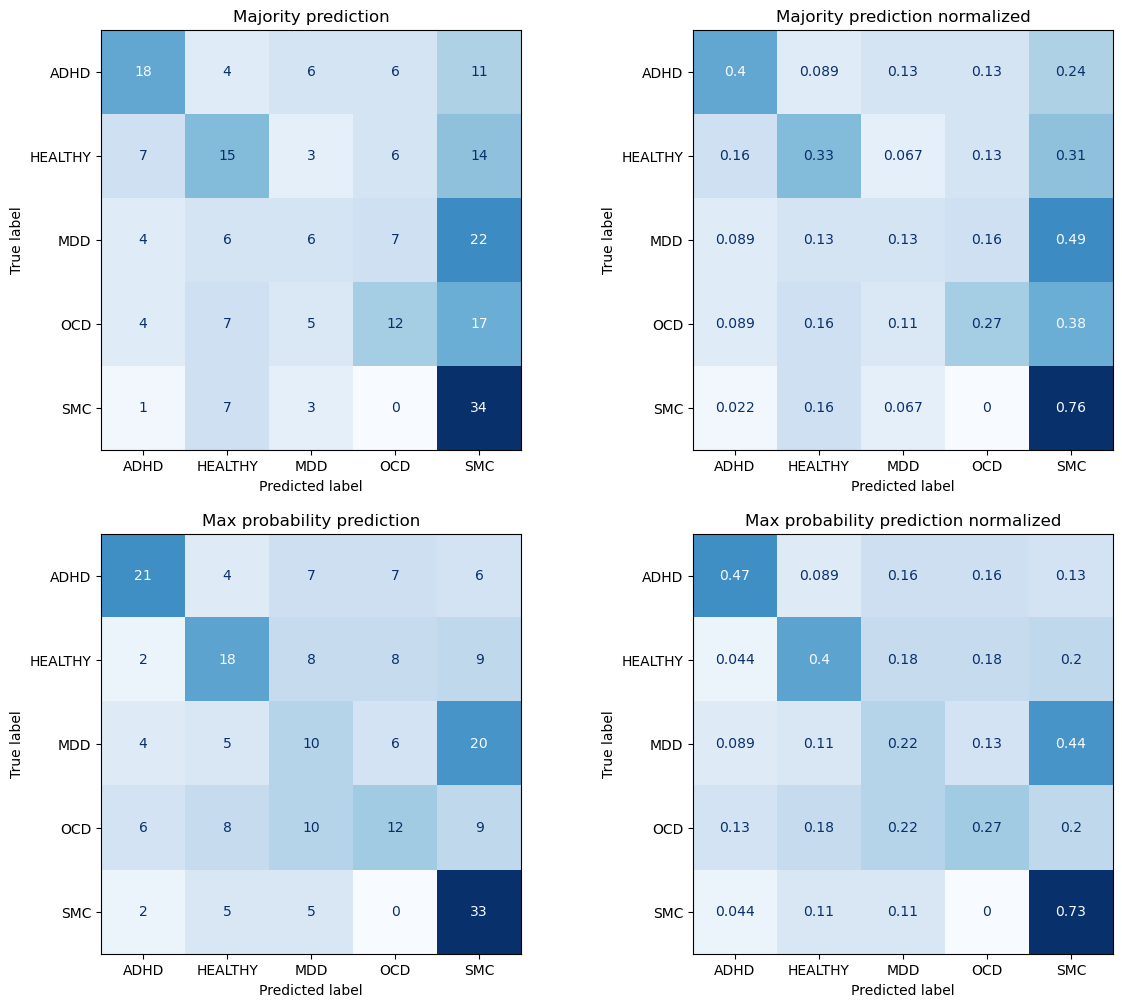

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### RF

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_rf_ratio.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_ratio['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_ratio.columns if 'ratio' in num_col]
 
X = df_stat_conn_features_ratio[numeric_cols]
Y = df_stat_conn_features_ratio['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[4:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('RF', RandomForestClassifier(**best_params))]
pipeline = Pipeline(steps)

# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_ratio['ID'], 'diagnosis': df_stat_conn_features_ratio['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_ratio.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

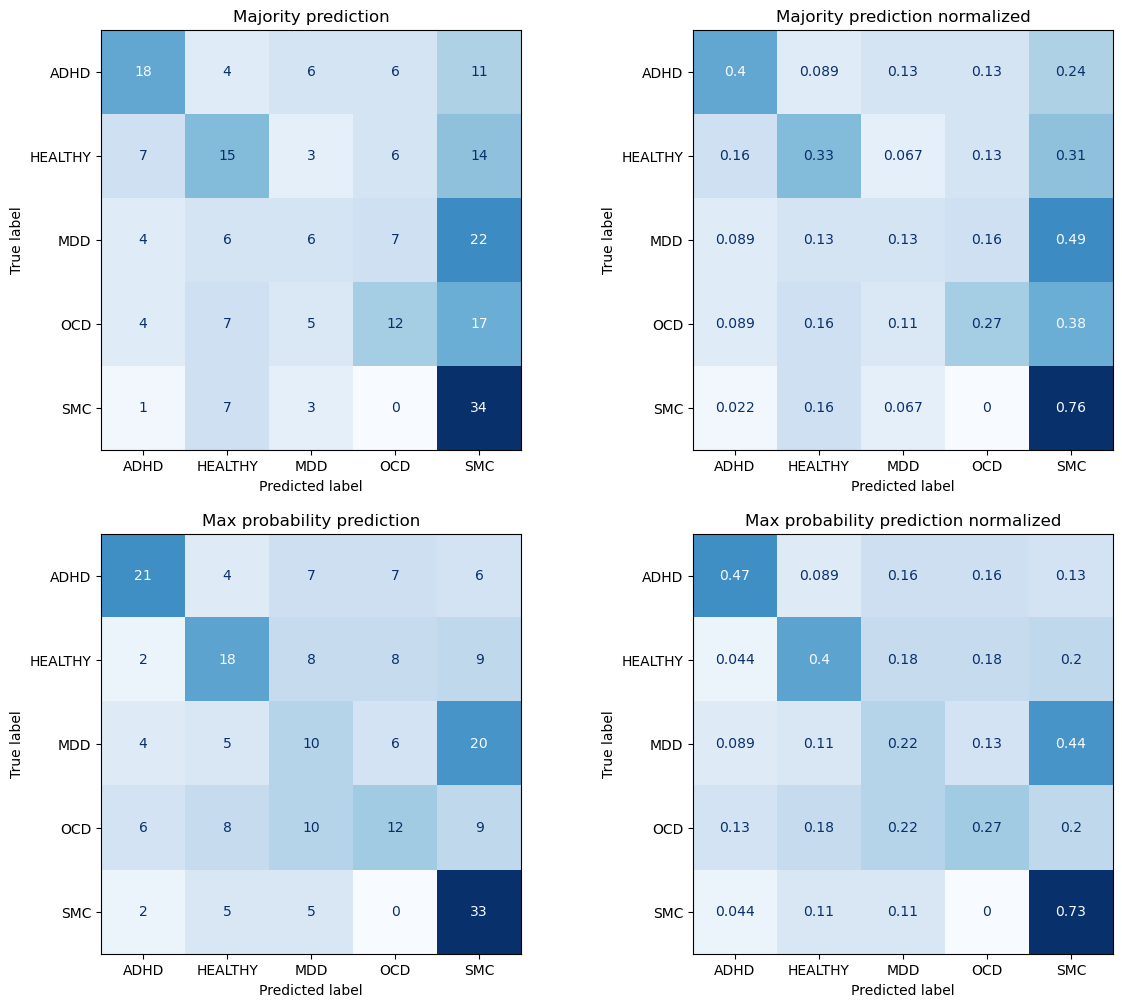

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

#### GBC

In [ ]:
# load nested cv results
nested_cv = joblib.load(r'D:\Documents\RU\Master_Neurobiology\Internship_jaar_2\Project\Notebooks\saved_models\nested_cv_statconn_gbc_ratio.pkl')
# obtain best model during nested CV
best_score_index = np.argmax(nested_cv['test_score'])
best_model = nested_cv['estimator'][best_score_index]
print('Parameters of the best model:', best_model.best_params_)

c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator StandardScaler from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator SimpleImputer from version 1.4.0 when using version 1.4.2. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(
c:\Users\tuur\anaconda3\envs\mne\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator Pipeline from version 1.4.0 when using version 1.4.2. This might

Parameters of the best model: {'rbf_svm__estimator__C': 1, 'rbf_svm__estimator__class_weight': 'balanced', 'rbf_svm__estimator__gamma': 0.1, 'rbf_svm__estimator__kernel': 'rbf'}


In [ ]:
# obtain the epoch-level predictions

cv_outer = StratifiedGroupKFold(n_splits = 5, shuffle=False) # shuffle=False, so splits will be the same across calls

# assign groups (IDs) for GroupKFold
groups = df_stat_conn_features_ratio['ID'].tolist()
print(f'# of instances: {len(groups)}')

# define numeric columns
numeric_cols = [num_col for num_col in df_stat_conn_features_ratio.columns if 'ratio' in num_col]
 
X = df_stat_conn_features_ratio[numeric_cols]
Y = df_stat_conn_features_ratio['diagnosis']
# label binarize diagnosis for ROC curve (alphabatic order by default)
# & label encode diagnosis for predictions
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
Y_one_hot = lb.fit_transform(Y)
print(Y_one_hot.shape)
le = preprocessing.LabelEncoder()
Y = le.fit_transform(Y)

# preprocessing steps for numerical features
numeric_transformer = Pipeline(steps = [
    ('scaler', StandardScaler()), # standardization
    ('impute', SimpleImputer(strategy='mean')) # mean imputation
])

col_trans = ColumnTransformer(transformers=[
    ('numeric_transformer', numeric_transformer, numeric_cols),
    ],
    remainder='drop',
    n_jobs=-1)

# get the hyperparameters from the best model of the nested CV
best_params = {}
for hyperparameter in best_model.best_params_:
    key = hyperparameter[5:]
    best_params[key] = best_model.best_params_[hyperparameter]
print(best_params)

steps = [('col_trans', col_trans), ('gbc', GradientBoostingClassifier(**best_params))]
pipeline = Pipeline(steps)
# obtain predictions
Y_pred = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1)    
Y_pred = le.inverse_transform(Y_pred)

# obtain proba predictions
Y_score = cross_val_predict(pipeline, X, Y,  cv = cv_outer, groups = groups, n_jobs=-1, verbose=1, method='predict_proba')

# save the predictions to a dataframe
df_predictions = pd.DataFrame(data = {'ID': df_stat_conn_features_ratio['ID'], 'diagnosis': df_stat_conn_features_ratio['diagnosis'], 'prediction': Y_pred, 'proba': Y_score.tolist()})


# of instances: 2700
(2700, 5)
{'C': 1, 'class_weight': 'balanced', 'gamma': 0.1, 'kernel': 'rbf'}


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   20.7s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done   5 out of   5 | elapsed:   18.5s finished


,ID,diagnosis,prediction,proba
607,sub-87968765,SMC,SMC,"[0.13473290533115861, 0.15907227918572153, 0.2..."
6742,sub-88067357,HEALTHY,SMC,"[0.1307165811157009, 0.13870123920041, 0.22340..."
7651,sub-88075593,ADHD,ADHD,"[0.34657838354946535, 0.16750529801013816, 0.1..."
926,sub-87970881,SMC,SMC,"[0.0298731494775718, 0.03736614443375455, 0.21..."
3905,sub-88041261,MDD,HEALTHY,"[0.20541402547230656, 0.4549846063430556, 0.11..."
63,sub-87966337,SMC,SMC,"[0.1666686614168704, 0.15705176095190584, 0.25..."
2443,sub-88022001,MDD,SMC,"[0.1672329089781105, 0.16166685325284813, 0.22..."


In [ ]:
## compute patient-level predictions
# group by 'ID' and get the most frequent prediction for each participant
most_frequent_predictions = df_predictions.groupby('ID')['prediction'].agg(lambda x: x.mode()[0])
most_frequent_predictions = most_frequent_predictions.reset_index()

# group by 'ID' and sum all probas per class for each participant
sum_probas = df_predictions.groupby('ID')['proba'].agg(lambda x: pd.DataFrame(x.tolist()).sum())
sum_probas = sum_probas.reset_index()

# get the index of the max value in the proba list
sum_probas['proba_prediction'] = sum_probas['proba'].apply(lambda x: np.argmax(x))
sum_probas['proba_prediction'] = le.inverse_transform(sum_probas['proba_prediction'])

# combine into single dataframe
df_patient_predictions = pd.merge(most_frequent_predictions, sum_probas[['ID', 'proba_prediction']], on = 'ID', how = 'inner')
df_patient_predictions['diagnosis'] = df_stat_conn_features_ratio.groupby('ID')['diagnosis'].first().values
df_patient_predictions.sample(5)

,ID,prediction,proba_prediction,diagnosis
138,sub-88049585,MDD,MDD,HEALTHY
182,sub-88063577,SMC,MDD,OCD
129,sub-88046393,ADHD,ADHD,ADHD
11,sub-87967729,SMC,SMC,SMC
151,sub-88053545,SMC,SMC,HEALTHY


In [ ]:
# compute performance metrics
Y = df_patient_predictions['diagnosis']
Y_majority = df_patient_predictions['prediction']
Y_proba = df_patient_predictions['proba_prediction']
class_labels = np.unique(Y)

# majority classification report
print('Majority prediction classification report:')
print(classification_report(Y, Y_majority, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_majority, average = 'weighted', zero_division=0))
print()

# proba classification report
print('Proba prediction classification report:')
print(classification_report(Y, Y_proba, target_names=class_labels))
print('f1_score:', f1_score(Y, Y_proba, average = 'weighted', zero_division=0))
print()

Majority prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.53      0.40      0.46        45
     HEALTHY       0.38      0.33      0.36        45
         MDD       0.26      0.13      0.18        45
         OCD       0.39      0.27      0.32        45
         SMC       0.35      0.76      0.48        45

    accuracy                           0.38       225
   macro avg       0.38      0.38      0.36       225
weighted avg       0.38      0.38      0.36       225

f1_score: 0.35612471942369656

Proba prediction classification report:
              precision    recall  f1-score   support

        ADHD       0.60      0.47      0.53        45
     HEALTHY       0.45      0.40      0.42        45
         MDD       0.25      0.22      0.24        45
         OCD       0.36      0.27      0.31        45
         SMC       0.43      0.73      0.54        45

    accuracy                           0.42       225
   macro avg     

Text(0.5, 1.0, 'Max probability prediction normalized')

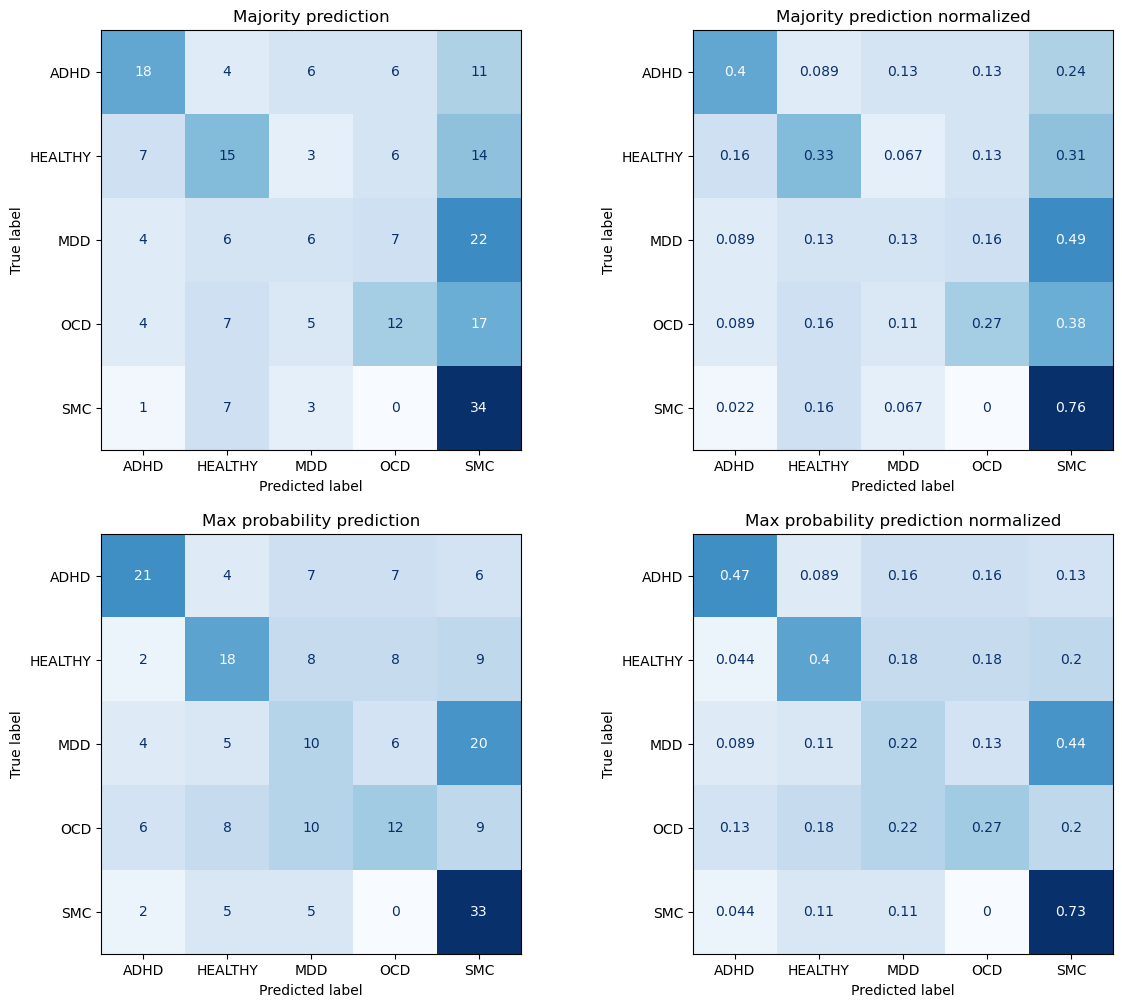

In [ ]:
# plot confusion matrices for majority and proba predictions (normalized and absolute predictions)
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
fig, ax = plt.subplots(2, 2, figsize = (14, 12))
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 0], colorbar=False, values_format='d')
ax[0, 0].set_title('Majority prediction')
conf_matrix = confusion_matrix(Y, Y_majority, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[0, 1], colorbar=False)
ax[0, 1].set_title('Majority prediction normalized')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels)
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 0], colorbar=False, values_format='d')
ax[1, 0].set_title('Max probability prediction')
conf_matrix = confusion_matrix(Y, Y_proba, labels = class_labels, normalize = 'true')
ConfusionMatrixDisplay(conf_matrix, display_labels=class_labels).plot(cmap='Blues', ax = ax[1, 1], colorbar=False)
ax[1, 1].set_title('Max probability prediction normalized')

## GNNs

### EC

#### standard GCN

#### GraphLambda without edge attributes

#### GraphLambda with edge attributes